# Seal Detection Model

## Load Model

In [1]:
%matplotlib inline
%load_ext tensorboard

import torch
import os
from tools.image import cv
from checkpoint import load_model
from evaluate import evaluate_image
from detection import display, detection_table
from matplotlib import pyplot as plt
from tools import struct
import random

import evaluate
from dataset.imports import load_dataset
from dataset.detection import collate_batch
from torch.utils.data.dataloader import DataLoader

out_dir = "./log/Seals"
model, encoder, args = load_model(f"{out_dir}/model.pth")
device = torch.cuda.current_device()
model = model.to(device)
encoder = encoder.to(device)
classes = args.dataset.classes

/home/fdi19/miniconda3/envs/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fdi19/miniconda3/envs/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/fdi19/miniconda3/envs/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def show(path, threshold=0.5):
    frame = cv.imread_color(path)
    nms_params = detection_table.nms_defaults._extend(threshold = threshold)
    results = evaluate_image(model, frame, encoder, nms_params = nms_params, device=device)

    d, p = results.detections, results.prediction
    detections = list(zip(d.label, d.bbox, d.confidence))

    seal_count = 0
    for label, bbox, confidence in detections:
        label_class = classes[label]
        seal_count += 1 if label_class.name == "seal" else 2
        display.draw_box(frame, bbox, confidence=confidence, scale=1.0,
            name=label_class.name, color=display.to_rgb(label_class.colour))
    print(seal_count, "seals")

    h, w = frame.shape[:2]
    scale = 7

    plt.figure(figsize = (w/h*scale, scale))
    plt.imshow(frame, interpolation='nearest')
    plt.show()

# Demonstration

## Scott Base

### 2019-20

Camera: CameraB
Image: D4049.jpg


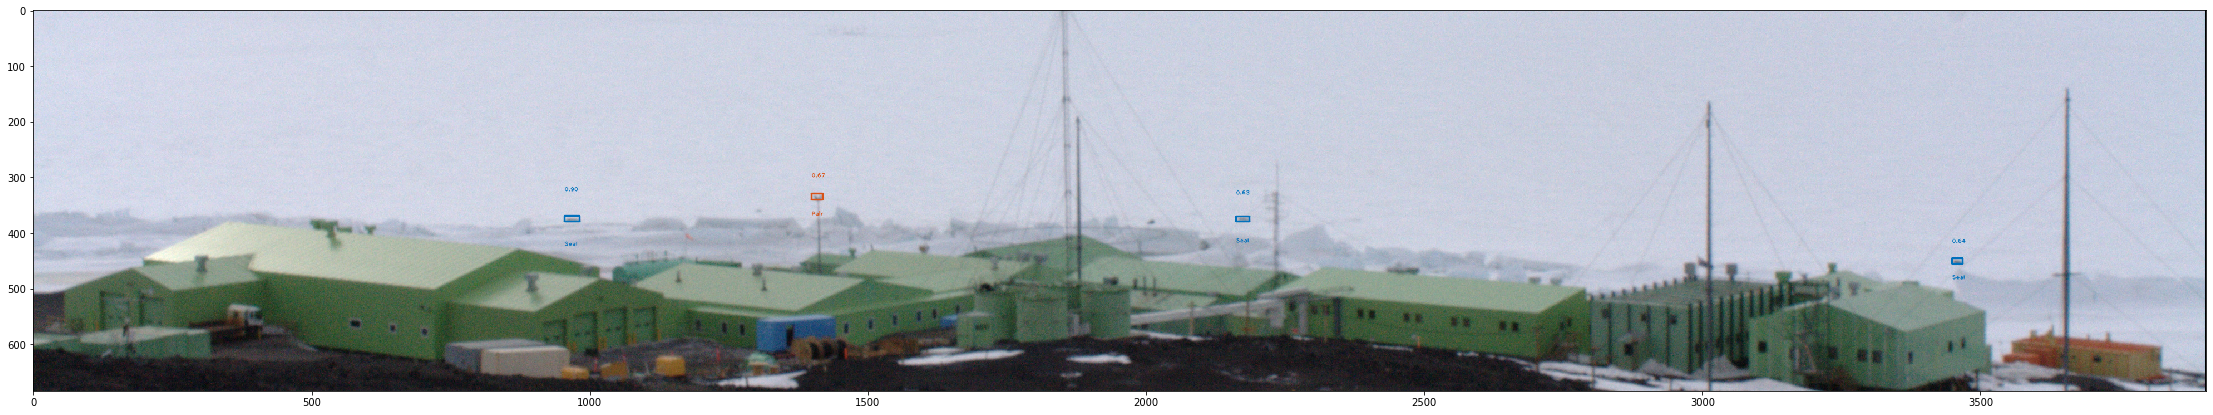

In [7]:
scott_base_2019 = "/home/fdi19/SENG402/data/images/scott_base/2019-20/"
camera = random.choice(os.listdir(scott_base_2019))
image = random.choice(os.listdir(scott_base_2019 + camera))
path = os.path.join(scott_base_2019, camera, image)
print(f'Camera: {camera}\nImage: {image}')
show(path)

### 2021-22

Image: 2022-01-16T03_33_38.jpg
3 seals


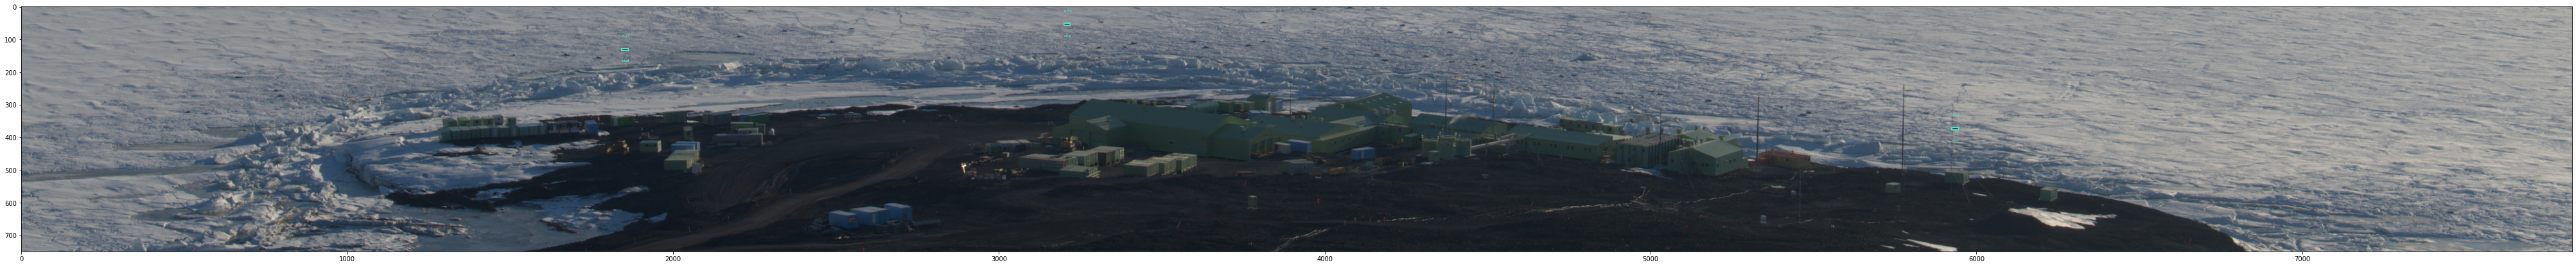

In [19]:
scott_base_2021 = "/home/fdi19/SENG402/data/images/scott_base/2021-22/"
image = random.choice(os.listdir(scott_base_2021))
path = os.path.join(scott_base_2021, image)
print(f'Image: {image}')
show(path)

# TensorBoard

In [ ]:
tb_dir = f"{out_dir}/tensorboard"
%tensorboard --logdir $tb_dir

# Evaluate

In [2]:
nms_params = struct(
    nms=0.5,
    threshold=0.5,
    detections=500)


eval_params = struct(
    overlap=200,
    split=True,
    image_size=(600, 600),
    batch_size=8,
    nms_params=nms_params,
    device=device,
    debug=None
)

input_params = struct(input=struct(choice='coco', parameters=struct(path='/home/fdi19/SENG402/data/annotations/export_coco-instance_segmentsai1_Seal_2022-22_v1.2.json', image_root='/home/fdi19/SENG402/data/images/scott_base/2021-22', split_ratio='70/0/30')))
eval_test = evaluate.eval_test(model.eval(), encoder, eval_params)
_, dataset = load_dataset(input_params)
images = dataset.validate_images
loader = iter(dataset.test_on(images, struct(augment=None, num_workers=4), encoder))

loading coco from: /home/fdi19/SENG402/data/annotations/export_coco-instance_segmentsai1_Seal_2022-22_v1.2.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2 classes found
found images:  49
['seal', 'pair']
using 2 classes, found 49 images, 49 annotated with 3079 instances at 62.84 per image
{'train': 34, 'test': 1, 'validate': 14}


['/home/fdi19/SENG402/data/images/scott_base/2021-22/2021-11-20T16_02_26.jpg']


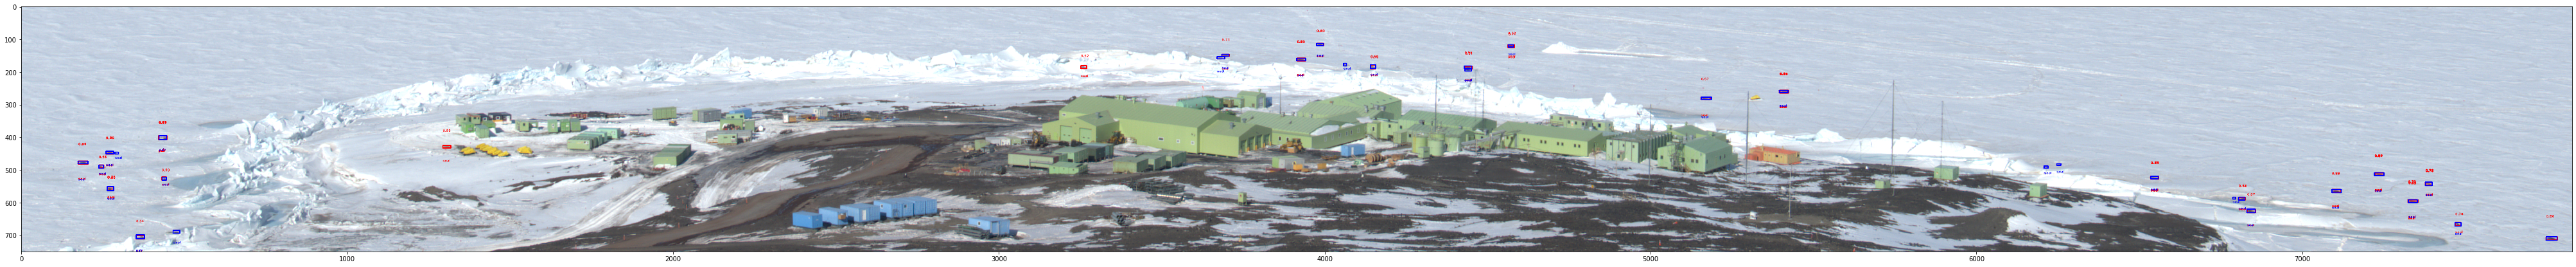

In [4]:
torch.cuda.empty_cache()
data = next(loader)
print(data.id)
result = eval_test(data)
frame = cv.imread_color(result.id[0])

for bbox, confidence, label, _ in list(zip(*result.detections.values())):
    label_class = classes[label]
    display.draw_box(frame, bbox, confidence=confidence, scale=1.0, name=label_class.name, color=display.to_rgb(hex(int('0xFF0000', 16))))

for bbox, label, _ in list(zip(*result.target.values())):
    label_class = classes[label]
    display.draw_box(frame, bbox, scale=1.0, name=label_class.name, color=display.to_rgb(hex(int('0x0000FF', 16))))

h, w = frame.shape[:2]
scale = 7
plt.figure(figsize = (w/h*scale, scale))
plt.imshow(frame, interpolation='nearest')
plt.show()